In [17]:
import json
import numpy as np
with open('/root/Datasets/Features/M003/landmarks/angry/level_1/00001/00001.json', 'r') as f:
    data = json.load(f)
data = np.asarray(data)
print(data.shape)

(68, 2)


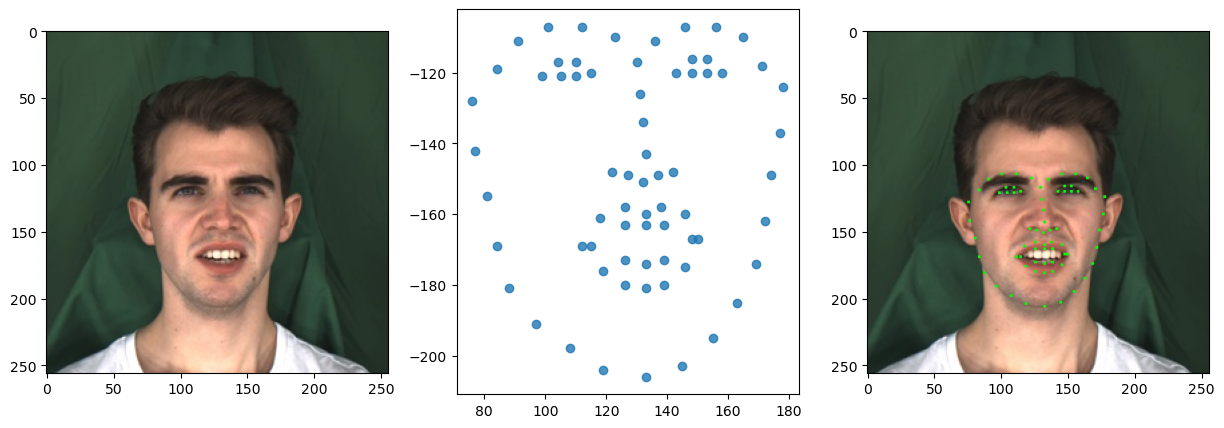

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('/root/Datasets/Features/M003/images/angry/level_1/00001/00001.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.asarray(image)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(image)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(data[:, 0], -data[:, 1], alpha=0.8)

ax = fig.add_subplot(1, 3, 3)
img2 = image.copy()
for p in data:
    img2[p[1]-1:p[1]+1, p[0]-1:p[0]+1, :] = (0, 255, 0)
ax.imshow(img2)
plt.show()

In [19]:
from evaluation.evaluation_landmark import calculate_LMD

import numpy as np
pred_landmark = np.load('./experiment/lm_pred.npy')
pred_landmark = pred_landmark.reshape(pred_landmark.shape[0], pred_landmark.shape[1], 68, 2)
print(pred_landmark.shape)

(1, 112, 68, 2)


In [20]:
import json
import os

gt_landmark = []
for filename in sorted(os.listdir('./experiment/001/')):
    with open(f'./experiment/001/{filename}') as f:
        data = json.load(f)
        gt_landmark.append(data['landmark'])
gt_landmark = np.asarray(gt_landmark)
gt_landmark = np.expand_dims(gt_landmark, axis=0)
print(gt_landmark.shape)

(1, 112, 68, 2)


In [21]:
gt_norm = np.sqrt(np.sum((gt_landmark[:, :, 36] - gt_landmark[:, :, 45])**2, axis=2))
nmse = calculate_LMD(pred_landmark, gt_landmark, norm_distance=gt_norm)
print(nmse)

0.08156857700341434


In [22]:
from evaluation.evaluation_landmark import calculate_LMV

gt_norm = np.sqrt(np.sum((gt_landmark[:, :, 36] - gt_landmark[:, :, 45])**2, axis=2))[:,:-1]
lmv = calculate_LMV(pred_landmark, gt_landmark, norm_distance=gt_norm)
print(lmv)

0.021824855368326047


In [23]:
import cv2

imageA = cv2.imread('/root/Datasets/Features/M003/images/angry/level_1/00001/00001.jpeg')
imageB = cv2.imread('/root/Datasets/Features/M003/images/angry/level_1/00001/00002.jpeg')

from evaluation.evaluation_image import *

ssim = calculate_ssim(imageA, imageB, channel_axis=2)
print(f'SSIM: {ssim}')

fid = calculate_fid(imageA, imageB, dims=192)
print(f'FID: {fid}')

imageA_grayscale = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
cpbd = calculate_cpbd(imageA_grayscale)
print(f'CPBD: {cpbd}')

psnr = calculate_psnr(imageA, imageB)
print(f'PSNR: {psnr}')

SSIM: 0.9751889584828888
FID: 0.014282377389829293
CPBD: 0.3740768094534712
PSNR: 39.62620700895594


In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [10]:
import sys
sys.path.append('.')

import torch
import argparse
import yaml
from dataloader.dataloader_import import *
from model.model_import import *
import json
from os.path import join

if __name__ == '__main__': 
    config = yaml.safe_load(open('/root/TalkingHead/config/config_MEAD_A13L68.yaml'))
    dataloader = globals()[config['dataloader_name']](config, is_train=False)
    if torch.cuda.is_available():
        model = globals()[config['model_name']](config)
    
    #Load pretrain
    model.load(load_optim = True)
    model.eval()

    mfcc_path = '/root/Datasets/Features/M003/mfcc/neutral/level_1/00001'
    lm_path = '/root/Datasets/Features/M003/landmarks/neutral/level_1/00001'
    mfcc_data_list, lm_data_list = dataloader.getDataset().read_data_from_path(mfcc_path, lm_path)

    x,y = torch.from_numpy(mfcc_data_list).unsqueeze(0), torch.from_numpy(lm_data_list).unsqueeze(0)
    y = y.reshape(*y.shape[0:2], -1)
    pred = model(x)

    pred = pred.reshape(*pred.shape[0:2], 68, 2).detach().numpy()
    y = y.reshape(*y.shape[0:2], 68, 2).detach().numpy()

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/test_MEAD_A13L68.json'

In [5]:
from evaluation.evaluation_landmark import calculate_LMD

lmd = calculate_LMD(pred, y)
print(lmd)

8.0951


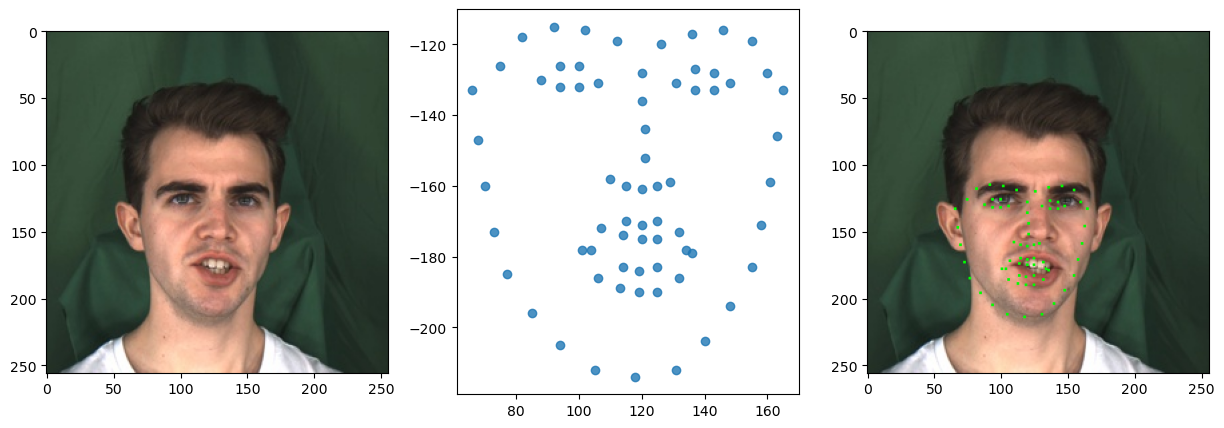

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('/root/Datasets/Features/M003/images/neutral/level_1/00001/00001.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.asarray(image)
landmarks = pred[0][0].astype(np.int32)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(image)

ax = fig.add_subplot(1, 3, 2)
ax.scatter(landmarks[:, 0], -landmarks[:, 1], alpha=0.8)

ax = fig.add_subplot(1, 3, 3)
img2 = image.copy()

psize = 1
for k, p in enumerate(landmarks):
    img2[p[1]-psize:p[1]+psize, p[0]-psize: p[0]+psize, :] = (0, 255, 0)
ax.imshow(img2)
plt.show()